# Stock Market Analysis using CNN-LSTM model
This project is about analysis of Stock Market and providing suggestions and predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Preprocessing and Analysis

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

First we'd read the CSV file and then drop the null columns. Then we'd check the columns (some not all)

In [3]:
# For data preprocessing and analysis part
data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
# Any CSV or TXT file can be added here....
data.dropna(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 199.4+ KB


In [5]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [6]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [7]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


After that, we'll visualize the data for understanding, this is shown below...

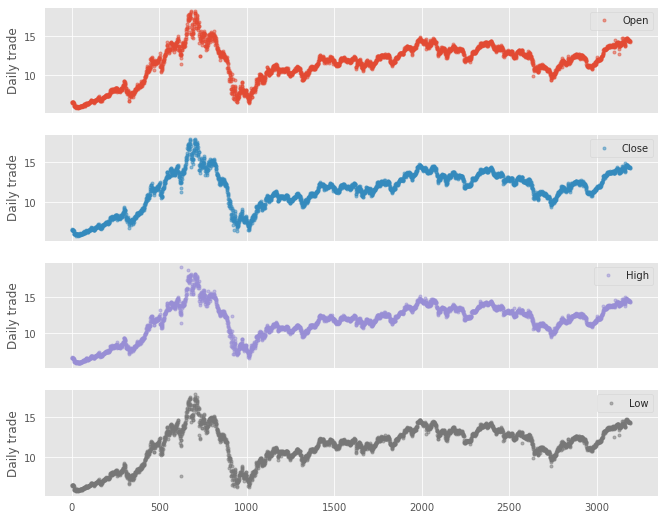

In [8]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

         Open     High      Low    Close  Volume  OpenInt
0      6.4987   6.6009   6.4668   6.5753   55766        0
1      6.6072   6.7669   6.5944   6.6263   49343        0
2      6.6391   6.6773   6.6072   6.6072   31643        0
3      6.5753   6.6072   6.5434   6.5816   27101        0
4      6.5753   6.6135   6.5562   6.5944   17387        0
...       ...      ...      ...      ...     ...      ...
3185  14.3998  14.4802  14.3900  14.4400   62423        0
3186  14.4400  14.4400  14.4000  14.4000    6722        0
3187  14.3400  14.4352  14.3400  14.3781    6304        0
3188  14.3300  14.3737  14.2800  14.3200   18761        0
3189  14.2500  14.3000  14.2400  14.3000   10658        0

[3190 rows x 6 columns]


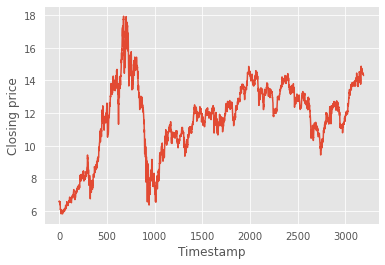

In [9]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")

df = data.drop('Date', axis=1)
print(df)

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [10]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,3]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 3] - first) / first)
    temp2.append((df.iloc[i + window_size, 3] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


## Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64. In every layer, TimeDistributed function is added to track the features with respect to time. In between them, Pooling layers are added.

Then a dense layer of 5 neurons with L1 Kernel regularizer is added

After that, it's passed to Bi-LSTM layers

In [11]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy

model = tf.keras.Sequential()

# Creating the Neural Network model here...
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

2021-11-09 13:29:56.634075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-09 13:30:00.438179: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-09 13:30:00.441584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-09 13:30:00.477708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 13:30:00.478322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-09 13:30:00.478390: I tensorflow/stream_executor/platform/def

Epoch 1/40


2021-11-09 13:30:08.853263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-09 13:30:09.585383: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-09 13:30:09.608611: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


62/62 [==============================] - 15s 36ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/40
62/62 [==============================] - 1s 12ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/40
62/62 [==============================] - 1s 9ms/step - loss: 0.0020 - mse: 0.0020 - v

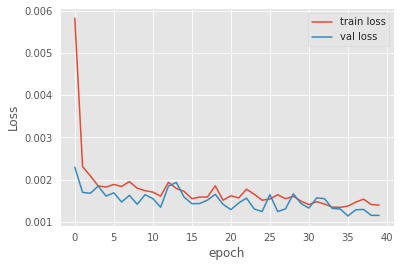

In [12]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 768)            0

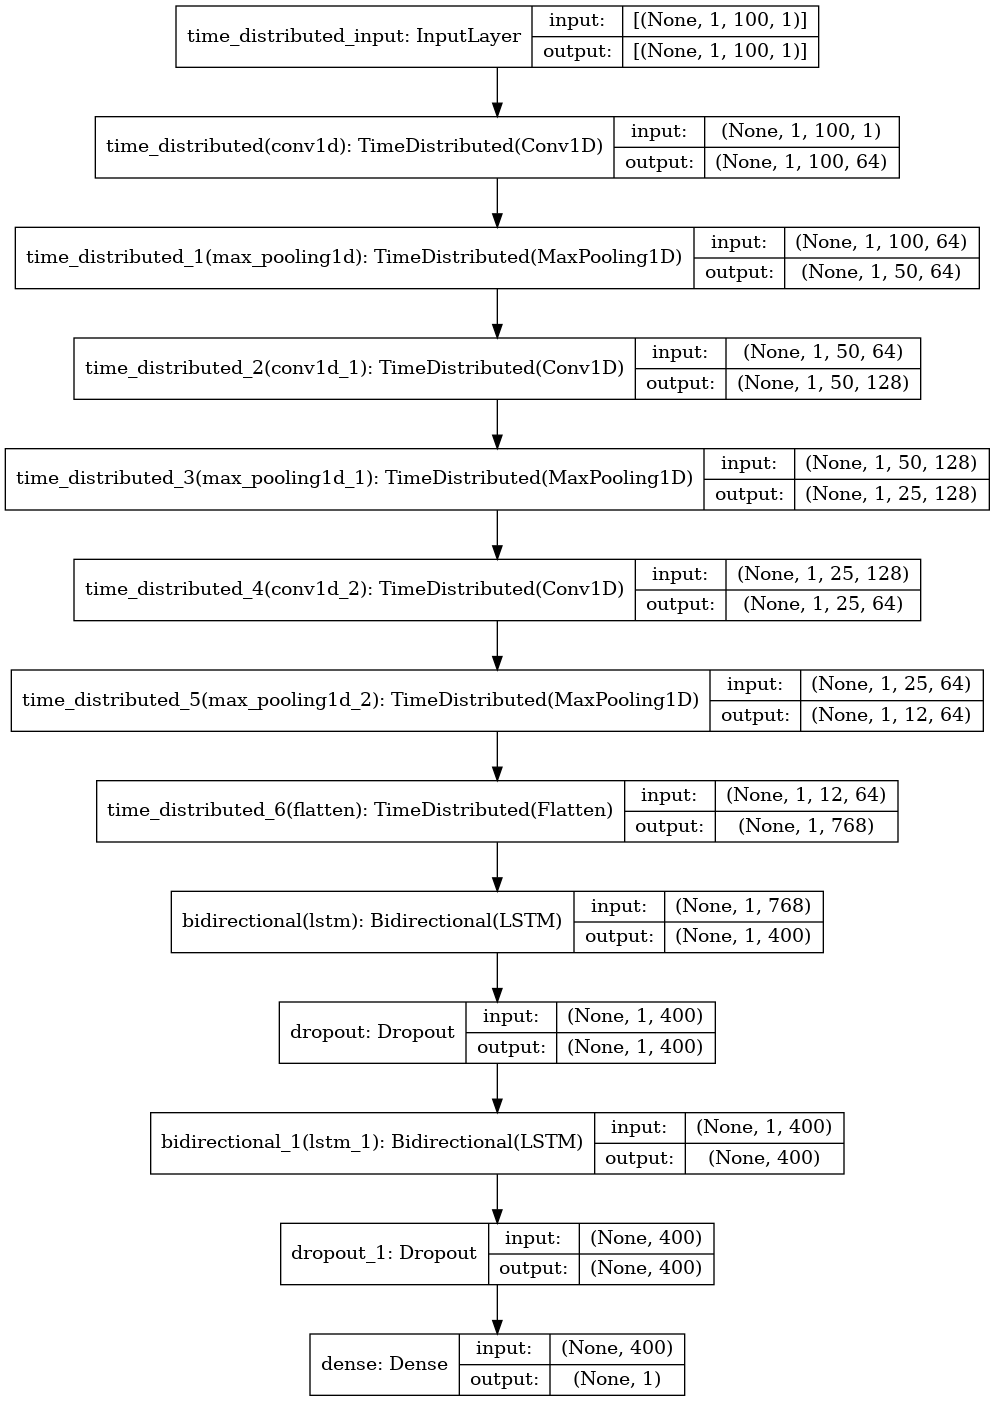

In [13]:
# After the model has been constructed, we need to train
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [14]:
model.evaluate(test_X, test_Y)

20/20 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011


[0.0011491446057334542, 0.0011491446057334542]

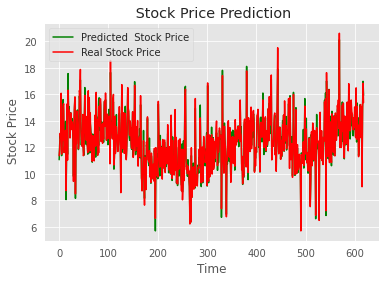

In [15]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

## Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [16]:
# First we need to save a model
model.save("model.h5")

In [17]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 768)            0

In [19]:
# For data preprocessing and analysis part
data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()

df2 = data2.drop('Date', axis=1)
print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,3]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 3] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 3] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

       Open     High      Low  Close   Volume  OpenInt
0     10.00  10.0900   9.3700   9.96   948900        0
1     10.06  10.4400  10.0000  10.10   253329        0
2     10.00  10.1800   9.7100  10.00    84800        0
3      9.95  10.0200   9.9200  10.00    74500        0
4      9.99  10.0000   9.8900   9.97    94000        0
...     ...      ...      ...    ...      ...      ...
1036  37.58  38.7200  36.7000  37.80  2388819        0
1037  37.98  38.0750  36.9700  37.89  3408164        0
1038  40.47  44.6432  39.1000  43.64  7669971        0
1039  43.00  44.2400  41.3441  43.20  2867311        0
1040  42.67  46.0717  42.5500  45.30  2967517        0

[1041 rows x 6 columns]
751
188


In [20]:
new_model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=64, verbose=1, shuffle =True)

Epoch 1/40
12/12 [==============================] - 5s 131ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 2/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 3/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 4/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 5/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 6/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 7/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 8/40
12/12 [==============================] - 0s 13ms/step - loss: 0.0225 - 

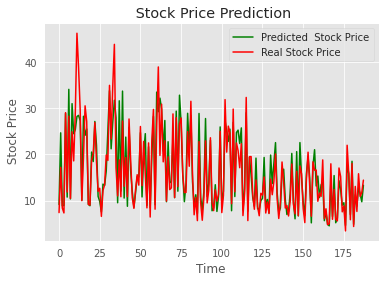

In [21]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()